In [2]:
# IMPORT
from IPython.display import Image, Math

import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from utils import *
import numpy as np
import pandas as pd
import pyAgrum
import pyAgrum.skbn as skbn
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.image as gimg
import pyAgrum.lib.dynamicBN as gdyn
import pyAgrum.causal as pyc
import pyAgrum.causal.notebook as cslnb
from pyAgrum.lib.discretizer import Discretizer
import re
import pickle
from sklearn.cluster import KMeans
from kneed import KneeLocator
from scipy.stats import iqr, gaussian_kde, entropy

In [3]:
def format_evidence_for_latex(evidence):
    formatted_evidence = []
    
    for var in evidence.keys():
        # Replace the part after the underscore with curly braces, if applicable
        var = re.sub(r'_(\w+)', r'_{\1}', var)  # Add {} around the part after the underscore
        
        # Replace '0' with '_{t-1}'
        var = var.replace('t', '_t')
        var = var.replace('0', '_{t-1}')

        # Append formatted variable to the list
        formatted_evidence.append(f"${var}$")  # Adding $ for LaTeX format
        
    return ', '.join(formatted_evidence)

def plot_distributions(var, distributions, var_midpoints, xlabel, ylabel):
    # Number of distributions to plot
    n = len(distributions)
    
    # Create subplots (one for each distribution)
    fig, axes = plt.subplots(1, n, figsize=(12, 4))

    # If there's only one plot, axes is not a list, so we handle it separately
    if n == 1:
        axes = [axes]
    var_midpoints = [round(float(m),2) for m in var_midpoints]
    for i, (data, title) in enumerate(distributions):
        # Plot the distribution in the corresponding subplot
        axes[i].bar(range(len(data)), data)
        axes[i].set_xticks(range(len(data)), var_midpoints)
        var_str = format_evidence_for_latex({var: None})
        axes[i].set_xlabel(xlabel)
        axes[i].set_ylabel(ylabel)
        axes[i].set_title(title)

    plt.tight_layout()
    plt.show()
    
def find_bin(value, edges):
    """
    Given a continuous value and an array of bin edges,
    return the index of the bin that contains the value.
    """
    idx = np.digitize(value, edges, right=False) - 1
    return int(max(0, min(idx, len(edges) - 2)))


def get_info(D, auditDict, var):
    if 'param' in auditDict[var] and isinstance(auditDict[var]['param'], list):
        edges = auditDict[var]['param']
        midpoints = [(edges[i] + edges[i+1]) / 2.0 for i in range(len(edges)-1)]
        return auditDict[var]['param'], edges, midpoints
    quantiles = np.linspace(0, 100, auditDict[var]['param'] + 1 if 'param' in auditDict[var] else auditDict[var]['nbBins'] + 1)
    edges = np.percentile(D[var].values, quantiles)
    midpoints = [(edges[i] + edges[i+1]) / 2.0 for i in range(len(edges)-1)]
    return quantiles, edges, midpoints


def optimal_bins_elbow_method(time_series, min_bins=2, max_bins=15, plot=True):
    """
    Determines the optimal number of bins using the elbow method with KMeans clustering.

    Parameters:
    - time_series: numpy array or list of numerical values (1D time series)
    - min_bins: minimum number of bins to consider
    - max_bins: maximum number of bins to consider
    - plot: whether to plot the elbow curve

    Returns:
    - optimal_bins: The optimal number of bins for discretization
    """
    time_series = np.array(time_series).reshape(-1, 1)  # Ensure data is 2D for KMeans

    inertia_values = []
    bin_range = range(min_bins, max_bins + 1)

    for k in bin_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(time_series)
        inertia_values.append(kmeans.inertia_)

    # Use KneeLocator to find the elbow point
    kneedle = KneeLocator(bin_range, inertia_values, curve="convex", direction="decreasing")
    optimal_bins = kneedle.elbow

    if plot:
        plt.figure(figsize=(8, 5))
        plt.plot(bin_range, inertia_values, marker="o", linestyle="-", label="Inertia")
        plt.axvline(optimal_bins, linestyle="--", color="red", label=f"Optimal Bins: {optimal_bins}")
        plt.xlabel("Number of Bins (Clusters)")
        plt.ylabel("Inertia (WCSS)")
        plt.title("Elbow Method for Optimal Bin Selection")
        plt.legend()
        plt.grid(True)
        plt.show()

    return optimal_bins



def optimal_bins(timeseries):
    """
    Determines the optimal number of bins for a given time series using
    the Freedman-Diaconis rule and KL Divergence comparison with KDE.

    Parameters:
    - timeseries: array-like, the time series data.

    Returns:
    - best_bins: int, the optimal number of bins.
    - best_method: str, the name of the best method.
    - all_bins: dict, dictionary of bins per method.
    """
    
    # Compute data range
    N = len(timeseries)
    range_data = np.max(timeseries) - np.min(timeseries)

    # Different binning rules
    bin_methods = {
        "Sturges": int(np.log2(N) + 1),
        "Rice": int(2 * N**(1/3)),
        "Scott": int(range_data / (3.5 * np.std(timeseries) / N**(1/3))),
        "Freedman-Diaconis": int(range_data / (2 * iqr(timeseries) / N**(1/3)))
    }

    # KDE estimation for ground truth density
    kde = gaussian_kde(timeseries)
    x_vals = np.linspace(np.min(timeseries), np.max(timeseries), 1000)
    kde_vals = kde(x_vals)

    # KL Divergence evaluation
    kl_scores = {}

    for name, bins in bin_methods.items():
        hist, bin_edges = np.histogram(timeseries, bins=bins, density=True)
        
        # Convert histogram to probability density function
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        hist_interp = np.interp(x_vals, bin_centers, hist, left=0, right=0)
        
        # Compute KL Divergence (measuring difference from KDE)
        kl_div = entropy(hist_interp + 1e-8, kde_vals + 1e-8)  # Small value to prevent log(0)
        kl_scores[name] = kl_div

    # Select the best binning method (lowest KL divergence)
    best_method = min(kl_scores, key=kl_scores.get)
    print(f"Best binning method: {best_method}")
    best_bins = bin_methods[best_method]

    return best_bins

In [4]:
def loaf_D(indir, bagname):
    for wp in WP:
        dfs = []
        if wp == WP.PARKING or wp == WP.CHARGING_STATION: continue
        for tod in TOD:
            if tod is TOD.OFF: continue
            files = [f for f in os.listdir(os.path.join(indir, "HH/my_nonoise", f"{bagname}", f"{tod.value}"))]
            files_split = [f.split('_') for f in files]
            wp_files = [f for f in files_split if len(f) == 3 and f[2].split('.')[0] == wp.value][0]
            wp_file = '_'.join(wp_files)
            print(f"Loading : {wp_file}")
            filename = os.path.join(indir, "HH/my_nonoise", f"{bagname}", f"{tod.value}", wp_file)

            df = pd.read_csv(filename)
            dfs.append(df)
        concat_df = pd.concat(dfs, ignore_index=True)
        break
 
    D = concat_df.drop('pf_elapsed_time', axis=1)
    D = D.drop('T', axis=1)
    D = D.drop('R_X', axis=1)
    D = D.drop('R_Y', axis=1)
    D = D.drop('G_X', axis=1)
    D = D.drop('G_Y', axis=1)
    D = D.drop('NP', axis=1)
    D = D.drop('R_B', axis=1)
    D = D.drop('C_S', axis=1)
    D = D.drop('TOD', axis=1)
    D = D.drop('WP', axis=1)
    D = D.drop('PD', axis=1)
    original_names = list(D.columns)
    D.columns = [f'{v}t' for v in original_names]

    # Add lagged variable
    for v in original_names:
        D[f'{v}0'] = np.concatenate([D[f'{v}t'].values[1:], [0]])
    D = D.iloc[1:].reset_index(drop=True)  # Remove first row
    D = D.iloc[:-1].reset_index(drop=True)  # Remove last row
    
    # D = D[(D['R_V0'] <= 0.1) | (D['R_V0'] >= 0.45)]
    # D = D[(D['R_Vt'] <= 0.1) | (D['R_Vt'] >= 0.45)]
    return D

In [5]:
INDIR = '/home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/hrisim_postprocess/csv'
test_01 = loaf_D(INDIR, 'test-obs-01')
# test_01 = loaf_D(INDIR, 'test-obs-015')
test_02 = loaf_D(INDIR, 'test-obs-02')
test_03 = loaf_D(INDIR, 'test-obs-03')
test_04 = loaf_D(INDIR, 'test-obs-04')
test_05 = loaf_D(INDIR, 'test-obs-05')

Loading : test-obs-01_H1_door-entrance.csv
Loading : test-obs-01_H2_door-entrance.csv
Loading : test-obs-01_H3_door-entrance.csv
Loading : test-obs-01_H4_door-entrance.csv
Loading : test-obs-01_H5_door-entrance.csv
Loading : test-obs-01_H6_door-entrance.csv
Loading : test-obs-01_H7_door-entrance.csv
Loading : test-obs-01_H8_door-entrance.csv
Loading : test-obs-01_H9_door-entrance.csv
Loading : test-obs-01_H10_door-entrance.csv
Loading : test-obs-02_H1_door-entrance.csv
Loading : test-obs-02_H2_door-entrance.csv
Loading : test-obs-02_H3_door-entrance.csv
Loading : test-obs-02_H4_door-entrance.csv
Loading : test-obs-02_H5_door-entrance.csv
Loading : test-obs-02_H6_door-entrance.csv
Loading : test-obs-02_H7_door-entrance.csv
Loading : test-obs-02_H8_door-entrance.csv
Loading : test-obs-02_H9_door-entrance.csv
Loading : test-obs-02_H10_door-entrance.csv
Loading : test-obs-03_H1_door-entrance.csv
Loading : test-obs-03_H2_door-entrance.csv
Loading : test-obs-03_H3_door-entrance.csv
Loading :

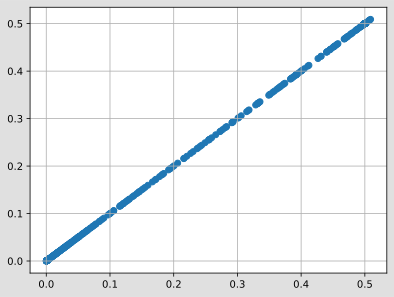

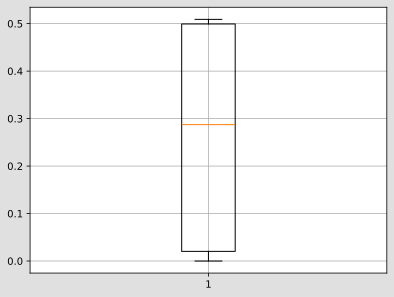

/tmp/ipykernel_75729/207120427.py:30: DeprecationWarning: 
  ** Discretizer.discretizedBN is deprecated since pyAgrum>1.15.0. Please use Discretizer.discretizeTemplate instead.
  
  template = discretizer.discretizedBN(target_D)  # Use one dataset to define structure
/tmp/ipykernel_75729/207120427.py:42: DeprecationWarning: 
  ** Discretizer.discretizedBN is deprecated since pyAgrum>1.15.0. Please use Discretizer.discretizeTemplate instead.
  
  discretized_D = discretizer.discretizedBN(D)  # Apply the same discretization


BN 1 learned.


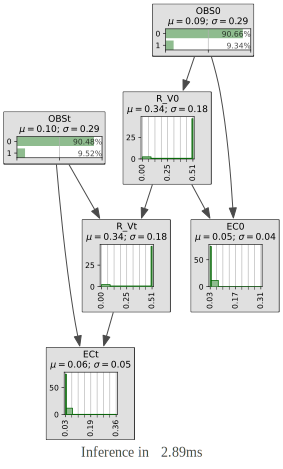

/tmp/ipykernel_75729/207120427.py:42: DeprecationWarning: 
  ** Discretizer.discretizedBN is deprecated since pyAgrum>1.15.0. Please use Discretizer.discretizeTemplate instead.
  
  discretized_D = discretizer.discretizedBN(D)  # Apply the same discretization


BN 2 learned.


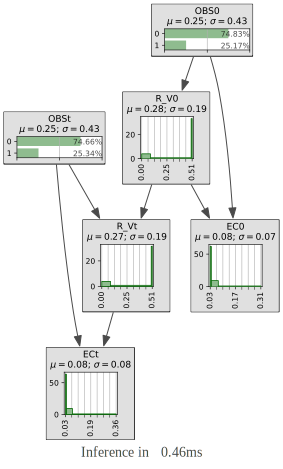

/tmp/ipykernel_75729/207120427.py:42: DeprecationWarning: 
  ** Discretizer.discretizedBN is deprecated since pyAgrum>1.15.0. Please use Discretizer.discretizeTemplate instead.
  
  discretized_D = discretizer.discretizedBN(D)  # Apply the same discretization


BN 3 learned.


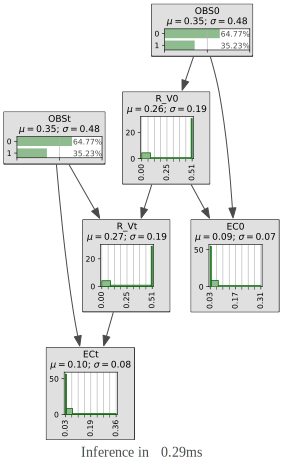

/tmp/ipykernel_75729/207120427.py:42: DeprecationWarning: 
  ** Discretizer.discretizedBN is deprecated since pyAgrum>1.15.0. Please use Discretizer.discretizeTemplate instead.
  
  discretized_D = discretizer.discretizedBN(D)  # Apply the same discretization


BN 4 learned.


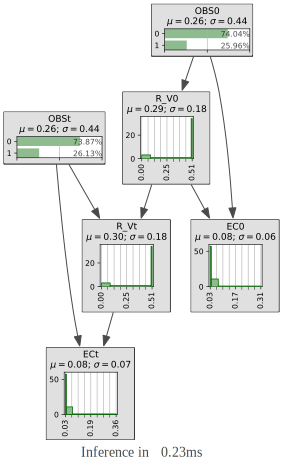

/tmp/ipykernel_75729/207120427.py:42: DeprecationWarning: 
  ** Discretizer.discretizedBN is deprecated since pyAgrum>1.15.0. Please use Discretizer.discretizeTemplate instead.
  
  discretized_D = discretizer.discretizedBN(D)  # Apply the same discretization


BN 5 learned.


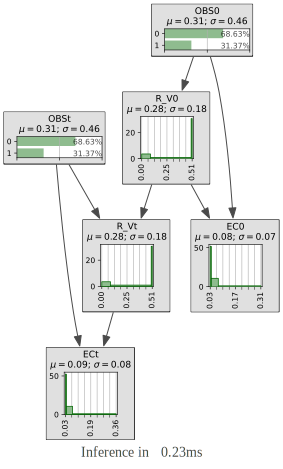

In [6]:
datasets = [test_01, test_02, test_03, test_04, test_05]

# DISCRETIZATION -- Compute binning once using one dataset (e.g., test_01)
discretizer = Discretizer(defaultDiscretizationMethod='quantile')
target_D = test_03
RV_bins = optimal_bins_elbow_method(target_D['R_Vt'].values, plot=False)
EC_bins = optimal_bins_elbow_method(target_D['ECt'].values, plot=False)

# Set the same binning for all datasets
# discretizer.setDiscretizationParameters('R_V0', 'quantile', 3)
# discretizer.setDiscretizationParameters('R_Vt', 'quantile', 3)
discretizer.setDiscretizationParameters('EC0', 'quantile', 3)
discretizer.setDiscretizationParameters('ECt', 'quantile', 3)
# discretizer.setDiscretizationParameters('R_V0', 'quantile', RV_bins)
# discretizer.setDiscretizationParameters('R_Vt', 'quantile', RV_bins)
# discretizer.setDiscretizationParameters('EC0', 'quantile', EC_bins)
# discretizer.setDiscretizationParameters('ECt', 'quantile', EC_bins)
discretizer.setDiscretizationParameters('R_V0', 'expert', [0, 0.088, 0.499, 0.509])
discretizer.setDiscretizationParameters('R_Vt', 'expert', [0, 0.088, 0.499, 0.509])
# discretizer.setDiscretizationParameters('R_V0', 'expert', [0, 0.010, 0.0106, 0.499, 0.509])
# discretizer.setDiscretizationParameters('R_Vt', 'expert', [0, 0.010, 0.0106, 0.499, 0.509])

plt.scatter(target_D['R_Vt'].values, target_D['R_Vt'].values)
plt.grid(True)
plt.show()
plt.boxplot(target_D['R_Vt'].values)
plt.grid(True)
plt.show()
# Define structure
template = discretizer.discretizedBN(target_D)  # Use one dataset to define structure
template.addArc("OBS0", "EC0")
template.addArc("OBS0", "R_V0")
template.addArc("R_V0", "EC0")
template.addArc("OBSt", "R_Vt")
template.addArc("OBSt", "ECt")
template.addArc("R_Vt", "ECt")
template.addArc("R_V0", "R_Vt")

# Learn parameters for each dataset
bns = []
for i, D in enumerate(datasets):
    discretized_D = discretizer.discretizedBN(D)  # Apply the same discretization
    auditDict=discretizer.audit(D)

    learner = pyAgrum.BNLearner(D, template)
    learner.useSmoothingPrior()
    bn = learner.learnParameters(template)
    bns.append(bn)
    print(f"BN {i+1} learned.")
    gnb.showInference(bn, size=10)


In [7]:
cms = []
for bn in bns:
    cm = pyc.CausalModel(bn)
    cms.append(cm)

In [8]:
target_var = 'ECt'
target_var_str = format_evidence_for_latex({target_var: None})
intervention_var = "R_Vt"

static_duration = 5
dynamic_duration = 4
charging_time = 2
LOAD_FACTOR = 5
ROBOT_MAX_VEL = 0.5
K_nl_s = 100 / (static_duration * 3600)
K_nl_d = (100 / (dynamic_duration * 3600) - K_nl_s)/(ROBOT_MAX_VEL)
K_l_s = K_nl_s * LOAD_FACTOR
K_l_d = K_nl_d * LOAD_FACTOR

quantiles_R_V, edges_R_V, midpoints_R_V = get_info(test_03, auditDict, intervention_var)
quantiles_EC, edges_EC, midpoints_EC = get_info(test_03, auditDict, target_var)
STEP = 5
time = 5

plot_fontsize = 20

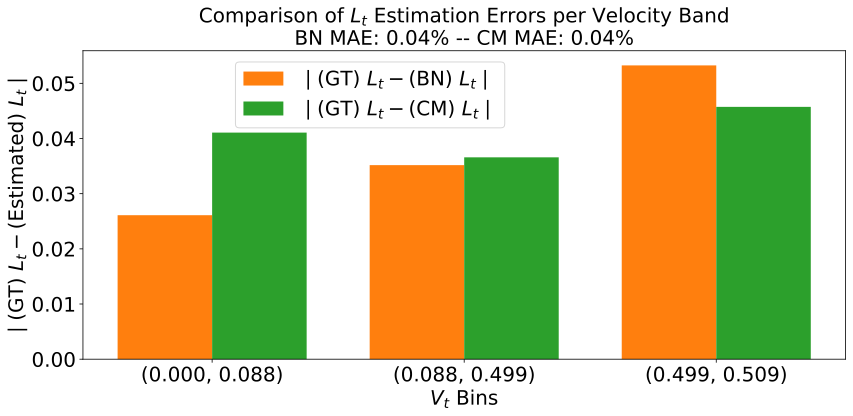

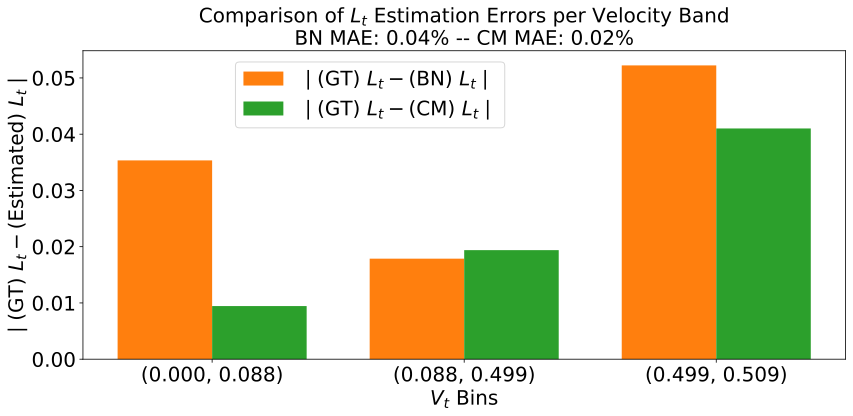

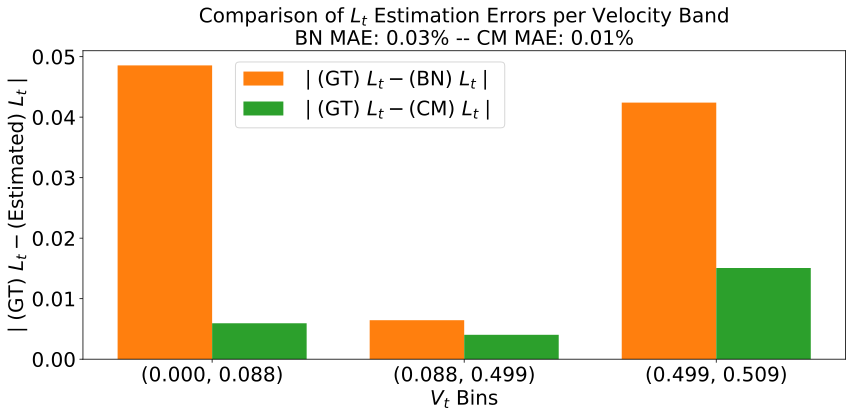

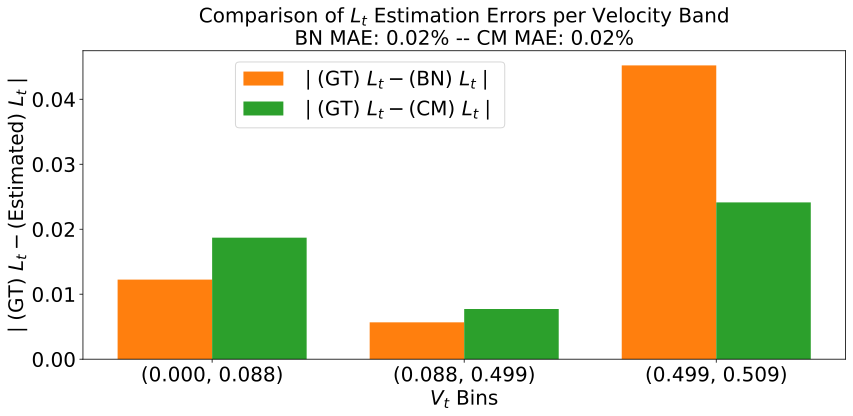

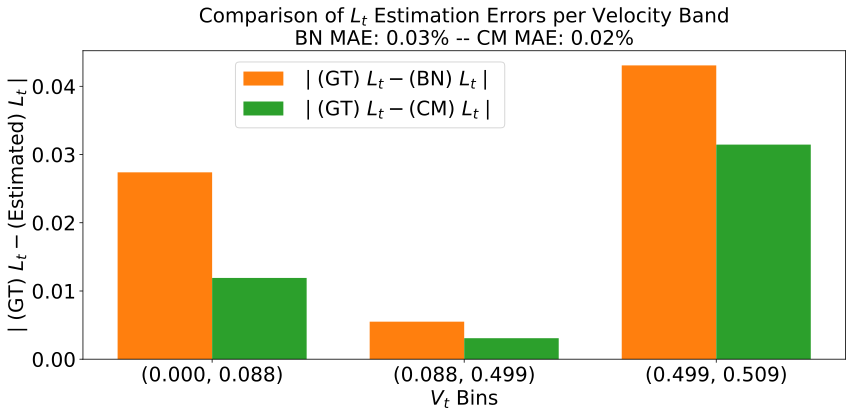

GT:
[[0.08516667 0.0955625  0.10433333]
 [0.08516667 0.0955625  0.10433333]
 [0.08516667 0.0955625  0.10433333]
 [0.08516667 0.0955625  0.10433333]]
BN:
[[0.12050841 0.07769262 0.05211251]
 [0.13371325 0.0891185  0.06192783]
 [0.09741217 0.08988611 0.05912432]
 [0.11255635 0.09006337 0.06127438]]
CM:
[[0.09460546 0.07617617 0.06331214]
 [0.09110074 0.09152991 0.08926653]
 [0.06646866 0.08784161 0.08020761]
 [0.07326024 0.092482   0.07287691]]
BN Error:
[[0.03534174 0.01786988 0.05222083]
 [0.04854658 0.006444   0.0424055 ]
 [0.0122455  0.00567639 0.04520902]
 [0.02738969 0.00549913 0.04305896]]
CM Error:
[[0.00943879 0.01938633 0.04102119]
 [0.00593408 0.00403259 0.0150668 ]
 [0.01869801 0.00772089 0.02412572]
 [0.01190643 0.0030805  0.03145642]]
BN Mean Abs Error: [0.03088088 0.00887235 0.04572357]
CM Mean Abs Error: [0.00380789 0.00855508 0.02791753]
BN RMSE: [0.03356321 0.01028736 0.04588891]
CM RMSE: [0.01240648 0.0107377  0.02950129]


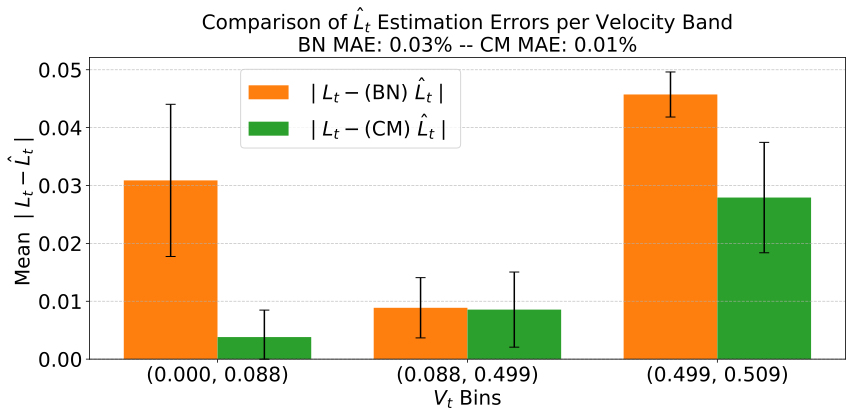

In [11]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'  # Set background to white globally
plt.rcParams['axes.facecolor'] = 'white'    # Set axis background to white
STEP = 5
time = 5
gt_noload = []
gt_load = []
gts = []
bayes_preds = []
causal_preds = []

RV_range = midpoints_R_V
for bn, cm in zip(bns, cms):
    tmp_gt_noload = []
    tmp_gt_load = []
    tmp_gts = []
    tmp_bayes_preds = []
    tmp_causal_preds = []
    for RV_val in RV_range:
        RV_bin_idx = find_bin(RV_val, edges_R_V)
        RV_val = midpoints_R_V[RV_bin_idx]
        GTLOAD = time * (K_l_s + K_l_d * RV_val) 
        GTNOLOAD = time * (K_nl_s + K_nl_d * RV_val)
        
        # --- BN prediction ---
        ie = pyAgrum.VariableElimination(bn)
        bn_prior = ie.posterior(target_var)
        evidence = {intervention_var: RV_bin_idx}
        evidence_str = format_evidence_for_latex(evidence)
        ie.setEvidence(evidence)
        ie.makeInference()
        bn_posterior = ie.posterior(target_var)
        bn_posterior_values = bn_posterior.toarray()
        pred_bn = sum(bn_posterior_values[j] * midpoints_EC[j] for j in range(len(bn_posterior_values)))
        bayes_pred = (time/STEP)*pred_bn
                
        # --- CausalModel prediction ---
        formula, adj, exp = pyc.causalImpact(cm, on=target_var, doing=intervention_var, values=evidence)
        posterior_causal = adj.toarray()
        pred_causal = sum(posterior_causal[j] * midpoints_EC[j] for j in range(len(posterior_causal)))
        causal_pred = (time/STEP)*pred_causal
                
        tmp_gt_noload.append(GTNOLOAD)
        tmp_gt_load.append(GTLOAD)
        tmp_gts.append((GTNOLOAD+GTLOAD)/2)
        tmp_bayes_preds.append(bayes_pred)
        tmp_causal_preds.append(causal_pred)
    gt_noload.append(tmp_gt_noload)
    gt_load.append(tmp_gt_load)
    gts.append(tmp_gts)
    bayes_preds.append(tmp_bayes_preds)
    causal_preds.append(tmp_causal_preds)

# Define bar width and offsets
x_indexes = np.arange(len(RV_range))

# Compute absolute errors
for i in range(len(bns)):

    cm_errors = np.abs(np.array(causal_preds[i]) - np.array(gts[i]))
    bn_errors = np.abs(np.array(bayes_preds[i]) - np.array(gts[i]))

    # Compute Mean Absolute Error (MAE)
    cm_MAE = np.mean(cm_errors)
    bn_MAE = np.mean(bn_errors)

    # Plot bars for each category with offset
    plt.figure(figsize=(12, 6))
    bar_width = 0.375
    plt.bar(x_indexes, bn_errors, width=bar_width, label=r"$\mid (\text{GT})~L_t - (\text{BN})~L_t \mid$", color='tab:orange', alpha=1)
    plt.bar(x_indexes + bar_width, cm_errors, width=bar_width, label=r"$\mid (\text{GT})~L_t - (\text{CM})~L_t \mid$", color='tab:green', alpha=1)
    
    # Labeling
    plt.xlabel(r"$V_t$ Bins", fontdict={'fontsize': plot_fontsize})
    plt.ylabel(r"$\mid (\text{GT})~L_t - (\text{Estimated})~L_t \mid$", fontdict={'fontsize': plot_fontsize})
    plt.xticks(x_indexes+bar_width/2, [f"({edges_R_V[i-1]:.3f}, {edges_R_V[i]:.3f})" for i in range(1, len(edges_R_V))], fontdict={'fontsize': plot_fontsize})  # Format x-axis labels
    plt.yticks(fontsize=plot_fontsize)  # Format x-axis labels
    plt.title(r"Comparison of $L_t$ " + f"Estimation Errors per Velocity Band\nBN MAE: {bn_MAE:.2f}% -- CM MAE: {cm_MAE:.2f}%", fontdict={'fontsize': plot_fontsize})
    plt.legend(fontsize=plot_fontsize, loc=(0.2, 0.75))
    plt.tight_layout()

    plt.show()
    
myGT = np.array(gts)[1:,:]
myBN = np.array(bayes_preds)[1:,:]
myCM = np.array(causal_preds)[1:,:]
    
print("GT:")
print(myGT)
print("BN:")
print(myBN)
print("CM:")
print(myCM)

print("BN Error:")
print(np.abs(myBN-myGT))
print("CM Error:")
print(np.abs(myCM-myGT))

print(f"BN Mean Abs Error: {np.abs(np.mean(myBN-myGT, axis=0))}")
print(f"CM Mean Abs Error: {np.abs(np.mean(myCM-myGT, axis=0))}")

print(f"BN RMSE: {np.sqrt(np.mean((myBN - myGT)**2, axis=0))}")
print(f"CM RMSE: {np.sqrt(np.mean((myCM - myGT)**2, axis=0))}")


# print("BN-CM Error:")
# print(np.abs(myBN-myGT)-np.abs(myCM-myGT))
    
bn_errors = np.abs(np.mean(myBN-myGT, axis=0))
cm_errors = np.abs(np.mean(myCM-myGT, axis=0))
# bn_errors = np.sqrt(np.mean((myBN - myGT)**2, axis=0))
# cm_errors = np.sqrt(np.mean((myCM - myGT)**2, axis=0))
# cm_errors = np.abs(np.mean(np.array(causal_preds)[[2,4], :], axis=0) - np.array(gts[0]))
# bn_errors = np.abs(np.mean(np.array(bayes_preds)[[2,4], :], axis=0) - np.array(gts[0]))

# Compute Mean Absolute Error (MAE)
cm_MAE = np.mean(cm_errors)
bn_MAE = np.mean(bn_errors)
#
bn_std = np.std(np.abs(myBN - myGT), axis=0)  # Standard deviation for BN errors
cm_std = np.std(np.abs(myCM - myGT), axis=0)  # Standard deviation for CM errors
# Compute the lower bound of error bars and ensure they stay >= 0
bn_lower_err = np.minimum(bn_errors, bn_std)  # Prevent BN errors from going below 0
cm_lower_err = np.minimum(cm_errors, cm_std)  # Prevent CM errors from going below 0

# Define yerr as asymmetric: [lower_error, upper_error]
bn_yerr = [bn_lower_err, bn_std]  
cm_yerr = [cm_lower_err, cm_std]  
# Plot bars for each category with offset
plt.figure(figsize=(12, 6))
bar_width = 0.375
plt.bar(x_indexes, bn_errors, width=bar_width, label=r"$\mid L_t - (\text{BN})~\hat{L}_t \mid$", color='tab:orange', yerr=bn_yerr, capsize=5, alpha=1)
plt.bar(x_indexes + bar_width, cm_errors, width=bar_width, label=r"$\mid L_t - (\text{CM})~\hat{L}_t \mid$", color='tab:green', yerr=cm_yerr, capsize=5, alpha=1)

# Labeling
plt.xlabel(r"$V_t$ Bins", fontdict={'fontsize': plot_fontsize})
plt.ylabel(r"Mean $\mid L_t - \hat{L}_t \mid$", fontdict={'fontsize': plot_fontsize})
plt.xticks(x_indexes+bar_width/2, [f"({edges_R_V[i-1]:.3f}, {edges_R_V[i]:.3f})" for i in range(1, len(edges_R_V))], fontdict={'fontsize': plot_fontsize})  # Format x-axis labels
plt.yticks(fontsize=plot_fontsize)  # Format x-axis labels
plt.title(r"Comparison of $\hat{L}_t$ " + f"Estimation Errors per Velocity Band\nBN MAE: {bn_MAE:.2f}% -- CM MAE: {cm_MAE:.2f}%", fontdict={'fontsize': plot_fontsize})
plt.legend(fontsize=plot_fontsize,  loc=(0.2, 0.7))
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [9]:
RV_val = 0.5
RV_bin_idx = find_bin(RV_val, edges_R_V)
RV_val = midpoints_R_V[RV_bin_idx]
GTLOAD = time * (K_l_s + K_l_d * RV_val) 
GTNOLOAD = time * (K_nl_s + K_nl_d * RV_val)

# --- BN prediction ---
ie = pyAgrum.VariableElimination(bn)
bn_prior = ie.posterior(target_var)
evidence = {intervention_var: RV_bin_idx}
evidence_str = format_evidence_for_latex(evidence)
ie.setEvidence(evidence)
ie.makeInference()
bn_posterior = ie.posterior(target_var)
bn_posterior_values = bn_posterior.toarray()
pred_bn = sum(bn_posterior_values[j] * midpoints_EC[j] for j in range(len(bn_posterior_values)))
bayes_pred = (time/STEP)*pred_bn
        
# --- CausalModel prediction ---
formula, adj, exp = pyc.causalImpact(cm, on=target_var, doing=intervention_var, values=evidence)
posterior_causal = adj.toarray()
pred_causal = sum(posterior_causal[j] * midpoints_EC[j] for j in range(len(posterior_causal)))
causal_pred = (time/STEP)*pred_causal
        
print(f"GT {(GTNOLOAD+GTLOAD)/2:.3f}")
print(f"BN {bayes_pred:.3f} -- AE {np.abs(bayes_pred - (GTNOLOAD+GTLOAD)/2):.3f}")
print(f"CM {causal_pred:.3f} -- AE {np.abs(causal_pred - (GTNOLOAD+GTLOAD)/2):.3f}")

GT 0.104
BN 0.061 -- AE 0.043
CM 0.073 -- AE 0.031


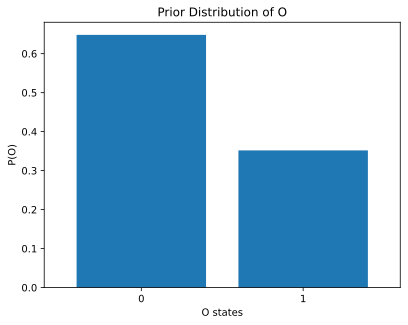

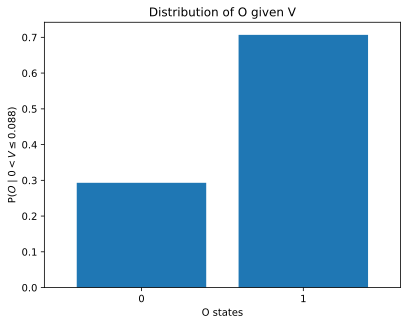

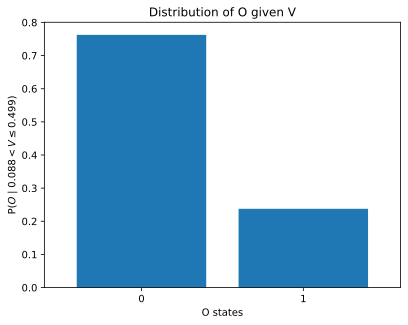

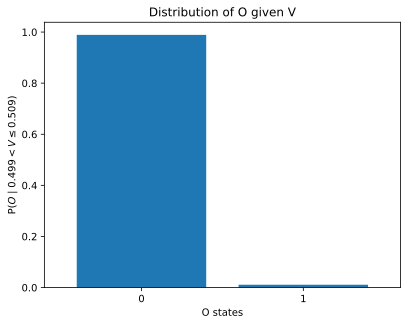

In [10]:
# OBS PRIOR DISTRIBUTION
D = test_03
R_V_selection = D
counts, bins = np.histogram(R_V_selection['OBSt'].values, bins=2)
plt.hist([0, 1], bins, weights=counts/sum(counts), width=0.4, alpha=1, label='OBS')
plt.xticks([0.2, 0.7], ['0', '1'])
plt.xlim([-0.1, 1])
plt.xlabel('O states')
plt.ylabel(f'P(O)')
plt.title(f"Prior Distribution of O")
plt.show()

# RV 
RV_bin_idx = find_bin(RV_val, edges_R_V)

## OBS GIVEN RV
R_V_selection = D[D['R_Vt'] <= 0.088]
counts, bins = np.histogram(R_V_selection['OBSt'].values, bins=2)
plt.hist([0, 1], bins, weights=counts/sum(counts), width=0.4, alpha=1, label='OBS')
plt.xticks([0.2, 0.7], ['0', '1'])
plt.xlim([-0.1, 1])
plt.xlabel('O states')
plt.ylabel(r'$\text{P}(O \mid 0 < V \leq 0.088)$')
plt.title(f"Distribution of O given V")
plt.show()

## OBS GIVEN RV
R_V_selection = D[(D['R_Vt'] > 0.088) & (D['R_Vt'] < 0.499)]
counts, bins = np.histogram(R_V_selection['OBSt'].values, bins=2)
plt.hist([0, 1], bins, weights=counts/sum(counts), width=0.4, alpha=1, label='OBS')
plt.xticks([0.2, 0.7], ['0', '1'])
plt.xlim([-0.1, 1])
plt.xlabel('O states')
plt.ylabel(r'$\text{P}(O \mid 0.088 < V \leq 0.499)$')
plt.title(f"Distribution of O given V")
plt.show()

## OBS GIVEN RV
R_V_selection = D[D['R_Vt'] >= 0.499]
counts, bins = np.histogram(R_V_selection['OBSt'].values, bins=2)
plt.hist([0, 1], bins, weights=counts/sum(counts), width=0.4, alpha=1, label='OBS')
plt.xticks([0.2, 0.7], ['0', '1'])
plt.xlim([-0.1, 1])
plt.xlabel('O states')
plt.ylabel(r'$\text{P}(O \mid 0.499 < V \leq 0.509)$')
plt.title(f"Distribution of O given V")
plt.show()

# ## BC GIVEN RV OBS = 0
# OBS_val = 0
# ie = pyAgrum.VariableElimination(bn)
# bn_prior = ie.posterior(target_var)
# evidence = {"R_Vt": RV_bin_idx, "OBSt": OBS_val}
# evidence_str = format_evidence_for_latex(evidence)
# ie.setEvidence(evidence)
# ie.makeInference()
# bn_posterior = ie.posterior(target_var)
# bn_posterior_values = bn_posterior.toarray()
# plot_distributions("ECt", [(bn_posterior_values, "")], midpoints_EC, xlabel="BC", ylabel=f"p(BC|OBS = {OBS_val}, RV = {RV_val})")

# ## BC GIVEN RV OBS = 1
# OBS_val = 1
# ie = pyAgrum.VariableElimination(bn)
# bn_prior = ie.posterior(target_var)
# evidence = {"R_Vt": RV_bin_idx, "OBSt": OBS_val}
# evidence_str = format_evidence_for_latex(evidence)
# ie.setEvidence(evidence)
# ie.makeInference()
# bn_posterior = ie.posterior(target_var)
# bn_posterior_values = bn_posterior.toarray()
# plot_distributions("ECt", [(bn_posterior_values, "")], midpoints_EC, xlabel="BC", ylabel=f"p(BC|OBS = {OBS_val}, RV = {RV_val})")

/tmp/ipykernel_635289/3644501717.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ytick_labels, fontsize=plot_fontsize)
/tmp/ipykernel_635289/3644501717.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ytick_labels, fontsize=plot_fontsize)
/tmp/ipykernel_635289/3644501717.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ytick_labels, fontsize=plot_fontsize)
/tmp/ipykernel_635289/3644501717.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ytick_labels, fontsize=plot_fontsize)


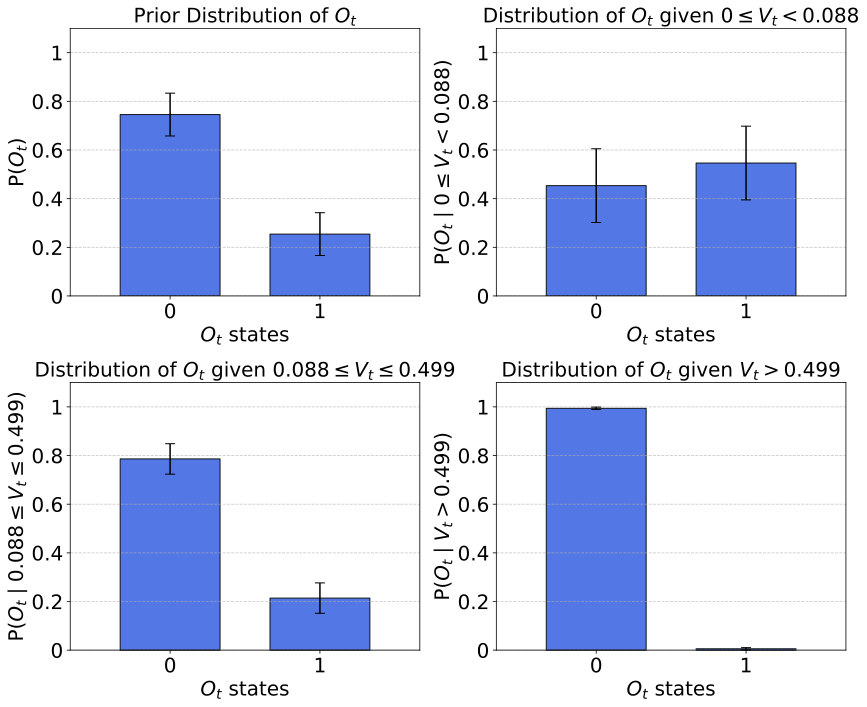

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# List of datasets
datasets = [test_01, test_02, test_03, test_04, test_05]

# Define bins for OBS states
obs_bins = [0.3, 0.6]
x_labels = [0.3, 0.6]
xtick_labels = ['0', '1']
ytick_labels = ['0', '0.2', '0.4', '0.6', '0.8', '1']

# Define conditions for R_Vt
rv_conditions = {
    'prior': (None, r'$\text{P}(O_t)$', "Prior Distribution of " + r'$O_t$'),
    'low': (lambda D: D[D['R_Vt'] < 0.088], r'$\text{P}(O_t \mid 0 \leq V_t < 0.088)$', "Distribution of " + r'$O_t$' + " given " + r'$0 \leq V_t < 0.088$'),
    'mid': (lambda D: D[(D['R_Vt'] >= 0.088) & (D['R_Vt'] <= 0.499)], r'$\text{P}(O_t \mid 0.088 \leq V_t \leq 0.499)$', "Distribution of " + r'$O_t$' + " given " + r'$0.088 \leq V_t \leq 0.499$'),
    'high': (lambda D: D[D['R_Vt'] > 0.499], r'$\text{P}(O_t \mid V_t > 0.499)$', "Distribution of " + r'$O_t$' + " given " + r'$V_t > 0.499$')
}

# Create dictionary to store results
hist_data = {key: [] for key in rv_conditions}

# Loop through datasets and compute properly normalized histograms
for D in datasets:
    for key, (filter_func, _, _) in rv_conditions.items():
        # Select data
        R_V_selection = D if filter_func is None else filter_func(D)
        
        if len(R_V_selection) == 0:
            # If no data, store [0,0] to avoid errors
            hist_data[key].append(np.array([0.0, 0.0]))
        else:
            # Compute histogram
            counts, _ = np.histogram(R_V_selection['OBSt'].values, bins=[-0.5, 0.5, 1.5])
            norm_counts = counts / np.sum(counts)  # Normalize to ensure sum is 1
            hist_data[key].append(norm_counts)

# Compute mean and std
mean_hist = {key: np.mean(hist_data[key], axis=0) for key in hist_data}
std_hist = {key: np.std(hist_data[key], axis=0) for key in hist_data}

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Plot each condition
for i, (key, (_, ylabel, title)) in enumerate(rv_conditions.items()):
    ax = axes[i]

    # Plot mean histogram with error bars
    ax.bar(obs_bins, mean_hist[key], yerr=std_hist[key], width=0.2, alpha=0.9, 
           color='royalblue', edgecolor='black', capsize=5)

    # Formatting
    ax.set_xticks(x_labels)
    ax.set_xticklabels(xtick_labels, fontsize=plot_fontsize)
    ax.set_yticklabels(ytick_labels, fontsize=plot_fontsize)
    ax.set_xlim([0.1, 0.8])
    ax.set_ylim([0, 1.1])  # Ensure probabilities stay between 0 and 1
    ax.set_xlabel(r'$O_t$ states', fontsize=plot_fontsize)
    ax.set_ylabel(ylabel, fontsize=plot_fontsize)
    ax.set_title(title, fontsize=plot_fontsize)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.show()
